In [233]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve,
    precision_score, recall_score, f1_score,accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_predict

<h2 style="text-align: center;">Instituto Superior de Engenharia de Lisboa</h2>  
<h3 style="text-align: center;">Licenciatura em Engenharia Informática e Multimédia</h3>
<p  style="margin-top:20px;text-align: center;">Aprendizagem Automática</p>
<p  style="text-align: center;">Semestre de Inverno 2024/2025</p>
<p  style="text-align: center;">1º Trabalho Prático</p>
<p  style="text-align: center;">Trabalho realizado por: </p>
<div style="margin:auto; display:flex"> 
    <ul style="margin:auto; display:block">
        <li>Alice Fernandes, Aluna Nº 45741</li>
        <li>Guilherme Mendes, Aluno Nº  49718</li>
        <li>Bruno, Aluno Nº 49755</li>
    </ul>
</div>

# Indíce
1. [Indíce de Figuras](#1---Indíce-de-Figuras)
2. [Introdução](#2---Introdução)
3. [Desenvolvimento](#3---Desenvolvimento)
4. [Conclusão](#4---Conclusão)
5. [Bibliografia](#5---Bibliografia)

# 2 - Introdução

A diabetes é uma doença crónica que afeta milhões de pessoas em todo o mundo, caracterizada por níveis elevados de glicose no sangue. O diagnóstico precoce e preciso desta condição é fundamental para prevenir complicações graves e melhorar a qualidade de vida dos pacientes.

Este trabalho utiliza o **Pima Indians Diabetes Dataset**, criado pelo National Institute of Diabetes and Digestive and Kidney Diseases (EUA), que contém informação sobre 768 mulheres da população indígena Pima, uma população com elevada incidência de diabetes. O dataset inclui 500 mulheres sem diabetes e 268 mulheres com diabetes, sendo cada observação caracterizada por 8 atributos clínicos relevantes: 
- número de gravidezes, 
- concentração de glicose plasmática, 
- pressão arterial diastólica, 
- espessura da dobra cutânea do tríceps, 
- nível sérico de insulina, 
- índice de massa corporal, 
- Diabetes Pedigree Function,
- Idade

O objetivo principal deste trabalho é desenvolver e comparar diferentes modelos de classificação binária capazes de determinar automaticamente se um paciente apresenta diabetes com base nas características fornecidas. Para tal, serão implementados e avaliados três classificadores, incluindo obrigatoriamente o Random Forest, utilizando metodologias adequadas de treino/teste e métricas apropriadas para avaliar o desempenho dos modelos.

Adicionalmente, será investigado o impacto da normalização dos dados no desempenho dos classificadores, analisando se a transformação dos dados para média nula e variância unitária contribui para melhorar a capacidade preditiva dos modelos.

O relatório apresenta uma análise dos resultados obtidos, justificando as escolhas realizadas e discutindo as decisões tomadas ao longo do desenvolvimento do trabalho.


# 3 - Desenvolvimento

Para este trabalho, foram selecionados três classificadores binários para a tarefa de classificação de diabetes. O **Random Forest Classifier** é um classificador obrigatório, baseado em ensemble de árvores de decisão. O **Support Vector Classifier (SVC)** é um algoritmo baseado em máquinas de vetores de suporte com diferentes kernels. A **Logistic Regression** é um modelo linear interpretável que utiliza a função logística.

A calibração dos hiperparâmetros será realizada através de GridSearchCV com validação cruzada (`StratifiedKFold` com 3 folds), garantindo uma exploração sistemática do espaço de hiperparâmetros e uma avaliação robusta dos modelos. Os dados serão divididos em **70% para treino+validação** e **30% para teste**, utilizando estratificação para manter a proporção de classes em ambos os conjuntos.

Para avaliar o desempenho dos classificadores, serão utilizadas várias métricas, incluindo a Matriz de Confusão, Precision, Recall e F1-Score, bem como as Curvas ROC e Precision-Recall. A avaliação será realizada tanto no conjunto de treino quanto no conjunto de teste para detetar possível overfitting. Será também investigado o impacto da **normalização dos dados** (transformação para média nula e variância unitária) no desempenho dos classificadores, bem como a aplicação de técnicas de redução de dimensionalidade como **PCA** e **LDA**.



## 3.1 - Carregamento e Análise Inicial dos Dados

Nesta secção, procede-se ao carregamento do dataset e à análise exploratória inicial dos dados, incluindo a exploração da estrutura do dataset, distribuição de classes e estatísticas descritivas.

O dataset é um problema de **classificação binária** onde:
- **Classe 0**: Paciente **não** tem diabetes (classe negativa)
- **Classe 1**: Paciente **tem** diabetes (classe positiva)

A variável `y` contém os _labels_ das classes (0 ou 1) para cada amostra, enquanto `X` contém os dados com 8 atributos por cada amostra.


In [234]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Carregar dados
data = pickle.load(open("pimaDiabetes.p", "rb"))
X = data['data']
y = data['target']

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")
print(f"\nNúmero total de amostras: {len(y)}")
print(f"Número de features: {X.shape[1]}")
print("\nClasses do dataset:")
print(f"  - Classe 0 (sem diabetes): {np.sum(y==0)} amostras ({ np.round(np.sum(y==0)/len(y)*100) }%)")
print(f"  - Classe 1 (com diabetes): {np.sum(y==1)} amostras ({ np.round(np.sum(y==1)/len(y)*100) }%)")


Shape de X (features): (768, 8)
Shape de y (target): (768,)

Número total de amostras: 768
Número de features: 8

Classes do dataset:
  - Classe 0 (sem diabetes): 500 amostras (65.0%)
  - Classe 1 (com diabetes): 268 amostras (35.0%)


O dataset apresenta um desequilíbrio entre as classes (65% vs 35%), com m amostras da classe 0 (sem diabetes) do que da classe 1 (com diabetes).

Este desequilíbrio justifica o uso de **estratificação** na divisão dos dados e na validação cruzada, garantindo que a proporção de classes seja mantida em todos os conjuntos (treino, validação e teste). Esta abordagem é essencial para obter uma avaliação real do desempenho dos classificadores, especialmente na detecção da classe com menos amostras (classe 1).


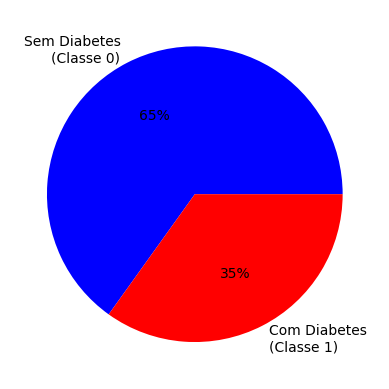

In [235]:
# Dados
classes = ['Sem Diabetes\n(Classe 0)', 'Com Diabetes\n(Classe 1)']
counts = [np.sum(y==0), np.sum(y==1)]
colors = ['blue', 'red']
# Gráfico de pizza
plt.pie(counts, labels=classes, colors=colors, autopct='%1.0f%%')

plt.show()

## 3.2 - Treino de Classificadores

Nesta secção vamos então treinar e avaliar três classificadores binários: `SVC`, `Random Forest Classifier` e `Logistic Regression`. 

Para a divisão dos dados, vamos dividir em 2/3 para treino e validação e 1/3 para teste, com estratificação para manter a proporção de classes em ambos os conjuntos. Esta divisão resulta 512 amostras para treino/validação e 256 amostras para teste, garantindo um conjunto de teste suficientemente grande para uma avaliação robusta.

A calibração dos hiperparâmetros de cada modelo será feita utilizando `GridSearchCV` com validação cruzada estratificada _StratifiedKFold_ com 5 _folds_ (este tipo de K-Fold mantêm a mesma distribuição de classes nos conjuntos). Esta abordagem permite-nos encontrar o melhor conjunto de hiperparametros.

Adicionalmente, para cada classificador, iremos também encontrar o melhor limiar de decisão utilizando validação cruzada. Em vez de usar o limiar de omissão, vamos testar vários limiares (entre 0 e 1) para encontrar aquele que obtém a melhor taxa de verdadeiros positivos, e minimiza os falsos positivos. Para isso, vamos usar a métrica `F1-Score`, que combina as métricas de `precision` e `recall` num único valor. O limiar usado pelo `scikit-learn` nos modelos de classificação binária é 0.5, que pode não ser o mais adequado para os dados que estamos a avaliar.

Para encontrar o limiar de decisão, vamos usar `cross_val_predict`, que treina modelos em cada _fold_ e prevê nas amostras de validação. O limiar encontrado é então aplicado ao conjunto de teste para avaliação final.

### 3.2.1 Métricas de Avaliação

Para avaliar o desempenho dos classificadores, utilizamos várias métricas complementares:

Matriz de Confusão: Tabela que resume as previsões do modelo, mostrando os Verdadeiros Positivos (TP), Verdadeiros Negativos (TN), Falsos Positivos (FP) e Falsos Negativos (FN). Esta matriz permite visualizar onde o modelo está a acertar e a errar, e é útil para identificar se o modelo está a confundir mais frequentemente a classe positiva com a negativa ou vice-versa.

- _Precision_: É uma métrica que ajuda a perceber se o modelo está a acertar corretamente na classificação das classes. É calculada como $\frac{TP}{TP+FP}$. Uma precisão alta indica que quando o modelo prevê diabetes, é provável que esteja correto. Esta métrica é importante quando o custo de um falso positivo é elevado (diagnosticar diabetes quando não existe).

- _Recall_: Esta métrica ajuda a perceber se o modelo consegue detetar todos os casos positivo. É calculada como  $\frac{TP}{TP+FN}$. Um _recall_ alto indica que o modelo consegue detetar a maioria dos casos de diabetes. Esta métrica é importante em problemas de classificação em que falsos negativos podem ter consequencias ao nivel do tratamento(deteção de diabetes quando o paciente não tem diabetes).

- _F1-Score_: É uma métrica que combina as métricas precision e recall. É calculada como $2 \times \frac{precision \times recall }{precision + recall }$.  Esta métrica dá mais importancia a valores baixos, e se a precision e o recall tiverem baixos indica que o nosso modelo não está a dar os melhores resultados.

- _Curva ROC_: Gráfico que mostra a relação entre e o Recall e Falsos Positivos (FP) para vários limiares. A área sob a curva ROC (AUC) varia entre 0 e 1, onde valores próximos de 1 indicam melhor capacidade do modelo discriminar entre classes. Esta curva permite-nos o desempenho de vários limiares, e perceber se o limiar usado é o melhor ou não.

_Curva Precision-Recall_: Gráfico que mostra a relação entre precision e recall para vários limiares. Esta curva foca-se no desempenho da classe positiva (diabetes), ao contrário da curva ROC que nos dá uma visão geral de como os vários limiares se comportam na classificação.

A avaliação será realizada tanto no conjunto de treino quanto no conjunto de teste para evitar o `overfitting` e garantir a capacidade de generalização dos modelos.

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3,stratify=y)
cv = StratifiedKFold(n_splits=3) # para o grid search mais tarde

In [237]:
# Funções utilitárias para os classificadores

# Plota duas matrizes de confusão lado a lado (treino e teste).
def plot_confusion_matrices(cm_train, cm_test, title_prefix):
    fig, axes = plt.subplots(1, 2, figsize=(9, 3))
    
    # Treino
    disp_train = ConfusionMatrixDisplay(cm_train)
    disp_train.plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title(f'{title_prefix} - Treino')
    
    # Teste
    disp_test = ConfusionMatrixDisplay(cm_test)
    disp_test.plot(ax=axes[1], cmap="Blues", colorbar=False)
    axes[1].set_title(f'{title_prefix} - Teste')
    
    plt.tight_layout()
    plt.show()

# Plota curva ROC (suporta plots fora e dentro de subplots)
def plot_roc_curve(fpr, tpr, roc_auc, threshold_point, model_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    ax.plot(fpr, tpr, color='blue', label='Curva ROC')
    
    ax.scatter(threshold_point[0], threshold_point[1], color='red', label='Limiar',)# Coloca o ponto do limiar a vermelho
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Curva ROC - {model_name}')
    ax.legend()
    ax.grid(True)
    
    if ax is None:
        plt.tight_layout()

def plot_precision_recall_curve(recall_vals, precision_vals, threshold_point, model_name, ax=None):
    ax.plot(recall_vals, precision_vals, color='green', label='Curva Precision-Recall')
    
    ax.scatter(threshold_point[0], threshold_point[1], color='red', label='Limiar',)
  
        
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Curva Precision-Recall - {model_name}')
    ax.legend()
    ax.grid(True)
    
    if ax is None:
        plt.tight_layout()
        plt.show()

def find_threshold(model, X_train, y_train, cv, param_grid=None):
    # Obter probabilidades previstas usando validação cruzada
    model.set_params(**param_grid) # aplicar parametros ao modelo
    
    y_train_proba_cv = cross_val_predict(
        model,
        X_train, 
        y_train,
        cv=cv,
        method='predict_proba'
    )[:, 1]
    
    # Testar diferentes limiares (de 0,1, 50 valores)
    threshold_candidates = np.linspace(0, 1, 50)
    f1_scores = []
    
    for threshold in threshold_candidates:
        y_pred_thresh = (y_train_proba_cv >= threshold).astype(int)
        f1_scores.append(f1_score(y_train, y_pred_thresh))
    
    # Encontrar o melhor limiar
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = threshold_candidates[best_threshold_idx]
    best_f1 = f1_scores[best_threshold_idx]
    
    return best_threshold, best_f1, f1_scores

# Plota todos os gráficos num subplot
def plot_threshold_analysis(fpr, tpr, roc_auc, recall_vals, precision_vals, cm_threshold, threshold_point_roc, threshold_point_pr, model_name=''):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    plot_roc_curve(fpr, tpr, roc_auc, threshold_point_roc, model_name, ax=axes[0])
    plot_precision_recall_curve(recall_vals, precision_vals, threshold_point_pr, model_name, ax=axes[1])
    
    # Matriz de confusão com limiar otimizado    
    disp_threshold = ConfusionMatrixDisplay(cm_threshold)    
    disp_threshold.plot(ax=axes[2], cmap='Blues')    
    axes[2].set_title('Confusion Matrix')
    
    plt.tight_layout()
    plt.show()


# Adicinei este def por enquanto vou deixar aqui
def plot_CF(cm_1, cm_2, title_prefix1, title_prefix2):
    fig, axes = plt.subplots(1, 2, figsize=(9, 3))
    
    # Mostra matriz de confusão 1, com o titlo desejado, title_prefix1
    disp_train = ConfusionMatrixDisplay(cm_1)
    disp_train.plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title(f'{title_prefix1}')
    
    # Mostra matriz de confusão 2, com o titlo desejado, title_prefix2
    disp_test = ConfusionMatrixDisplay(cm_2)
    disp_test.plot(ax=axes[1], cmap="Blues", colorbar=False)
    axes[1].set_title(f'{title_prefix2}')
    
    plt.tight_layout()
    plt.show()

### 3.2.1 - SVC 

In [ ]:
# Definir os hiperparâmetros
# https://stackoverflow.com/questions/72101295/python-gridsearchcv-taking-too-long-to-finish-running

def calibrate_svc(param_grid_svc, X_dataset,y_dataset, cv):
    grid_search_svc = GridSearchCV(
    estimator=SVC(probability=True, random_state=42, cache_size=1000), # aumentar o cache size
        param_grid=param_grid_svc,
        cv=cv,
        n_jobs=-1, #-1 é para usar todos os cores em processamento paralelo
    )

    # Treinar o modelo com GridSearchCV
    grid_search_svc.fit(X_dataset, y_dataset)  
    print(grid_search_svc.best_params_)

    # Usar o melhor modelo encontrado
    return grid_search_svc.best_estimator_, grid_search_svc.best_params_

# Final params
param_grid_svc = {
    'C': [0.5, 1, 5,  10, 1000],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001,],
}

param_grid_svc = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 5, 10, 100],
    'gamma': ['scale', 0.1, 0.01, 0.001],
    'degree': [2, 3], # só usado quando kernel='poly', acima de 3 aumenta risco de overfitting
    'class_weight': [None, 'balanced'],
}

svc_calibrated, svc_best_params = calibrate_svc(param_grid_svc,X_train,y_train, cv)



{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}



Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       333
           1       0.72      0.59      0.65       179

    accuracy                           0.78       512
   macro avg       0.76      0.73      0.74       512
weighted avg       0.77      0.78      0.77       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       167
           1       0.74      0.55      0.63        89

    accuracy                           0.78       256
   macro avg       0.77      0.72      0.74       256
weighted avg       0.77      0.78      0.77       256



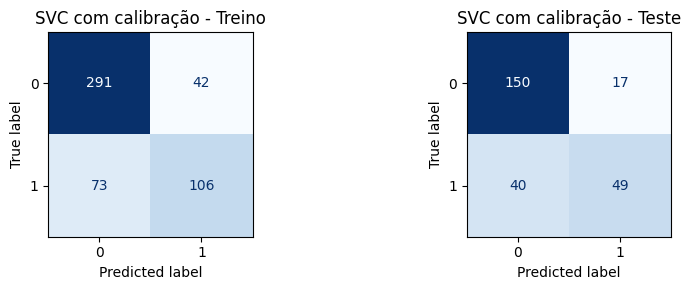

In [239]:
# Previsões no conjunto de treino
def predict_svc(svc_model, X_train,y_train,X_test,y_test ):
    y_train_pred_cal = svc_model.predict(X_train)
    print("\nDesempenho no conjunto de Treino")
    print(classification_report(y_train, y_train_pred_cal))
    cm_train_cal = confusion_matrix(y_train, y_train_pred_cal)

    # Previsões no conjunto de teste
    y_test_pred_cal = svc_model.predict(X_test)
    print("\nDesempenho no conjunto de Teste")
    print(classification_report(y_test, y_test_pred_cal))
    cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

    # Plotar matrizes de confusão usando a função
    plot_confusion_matrices(cm_train_cal, cm_test_cal, 'SVC com calibração')
    
    
predict_svc(svc_calibrated, X_train,y_train,X_test,y_test)

Limiar (validação cruzada): 0.3061224489795918
F1-Score com limiar: 0.6829268292682927
F1-Scores: [0.5180897250361794, 0.5219941348973607, 0.5274074074074074, 0.5357686453576864, 0.5623003194888179, 0.5794701986754967, 0.6048951048951049, 0.6290909090909091, 0.6367041198501873, 0.649706457925636, 0.6639175257731958, 0.6680851063829787, 0.6784922394678492, 0.6712328767123288, 0.6762589928057554, 0.6829268292682927, 0.6683544303797468, 0.6666666666666666, 0.6542553191489362, 0.6338797814207651, 0.6295264623955432, 0.6210826210826211, 0.6180758017492711, 0.6172106824925816, 0.6144578313253012, 0.6130030959752322, 0.6056782334384858, 0.6032786885245902, 0.5866666666666667, 0.564625850340136, 0.5614035087719298, 0.5519713261648745, 0.49624060150375937, 0.49429657794676807, 0.4728682170542636, 0.45161290322580644, 0.4214876033057851, 0.3829787234042553, 0.34782608695652173, 0.32142857142857145, 0.2777777777777778, 0.26291079812206575, 0.22966507177033493, 0.1951219512195122, 0.13265306122448

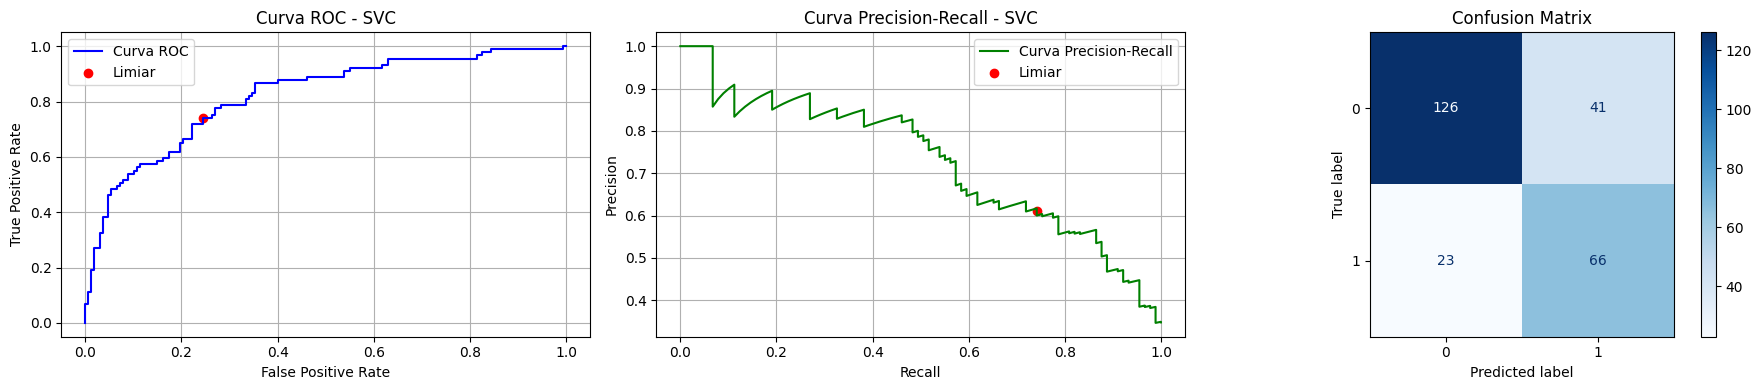

In [240]:
# Encontrar o limiar ótimo usando validação cruzada
def svc_with_threshold(X_train, y_train,X_test,y_test, cv,svc_best_params, svc_calibrated):
    best_threshold_f1, best_cv_f1, f1_scores = find_threshold(
        SVC(probability=True, random_state=42),
        X_train,
        y_train,
        cv,
        param_grid=svc_best_params
    )

    print(f"Limiar (validação cruzada): {best_threshold_f1}")
    print(f"F1-Score com limiar: {best_cv_f1}")
    print(f"F1-Scores: {f1_scores}")

    # Obter probabilidades no conjunto de teste e aplicar novo limiar apenas á classe positiva
    y_test_proba = svc_calibrated.predict_proba(X_test)
    y_test_proba = y_test_proba[:,1] # Obtem as probabiliades da classe positiva
    y_test_pred_threshold = (y_test_proba >= best_threshold_f1).astype(int)

    print(f"\nDesempenho com limiar ({best_threshold_f1}):") # ISTO ESTÁ REPETIDO
  
    # Calcular curvas para visualização
    # fp -> false positive
    # tp -> true positive
    fp, tp, thresholds_roc = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fp, tp)
    print("ROC AUC Score:", roc_auc)
    
    print(classification_report(y_test, y_test_pred_threshold))

    precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

    # thresholds_pr - best_threshold_f1 calcula a distancia entre 2 arrays
    # retorna a distancia absoluta, e nós queremos o valor minimo, que seria o limiar mais próximo, com base no f1-score
    # np.argmin retorna o index do array correspondente a valor do array que tem a menor distancia
    idx_closest = np.argmin(np.abs(thresholds_pr - best_threshold_f1))

    cm_test = confusion_matrix(y_test, y_test_pred_threshold)

    # Calcular pontos para os gráficos com limiar otimizado
    fp_threshold = cm_test[0, 1] / cm_test[0, :].sum()  # FP / (TN + FP)
    tp_threshold = cm_test[1, 1] / cm_test[1, :].sum()  # TP / (TP + FN)

    plot_threshold_analysis(
        fp, tp, roc_auc,
        recall_vals, precision_vals,
        cm_test,
        (fp_threshold, tp_threshold),
        (recall_vals[idx_closest], precision_vals[idx_closest]),
        'SVC',
    )

svc_with_threshold(X_train, y_train,X_test,y_test, cv,svc_best_params, svc_calibrated)

### 3.2.2 - Random Forest Classifier (Gui)

#### TODO:
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar


Vamos agora treinar um outro classificador, obrigatório para este trabalho, o Random Forest Classifier

Score dos dados de treino: 1.0
Score dos dados de teste: 0.73046875


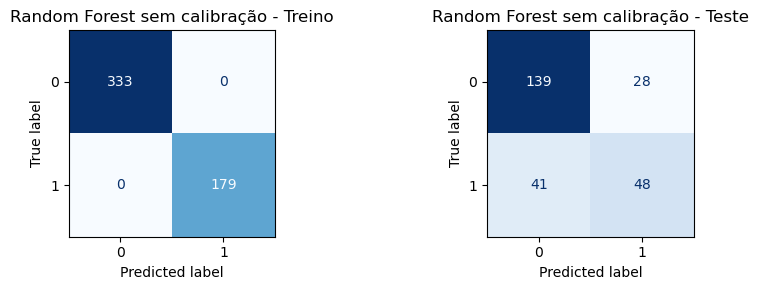

In [31]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

# Previsões no conjunto de treino
y_train_pred_cal = rf.predict(X_train)
# print("\nDesempenho no conjunto de Treino")
# print(classification_report(y_train, y_train_pred_cal))
cm_train_cal = confusion_matrix(y_train, y_train_pred_cal)

# Previsões no conjunto de teste
y_test_pred_cal = rf.predict(X_test)
# print("\nDesempenho no conjunto de Teste")
# print(classification_report(y_test, y_test_pred_cal))
cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

print('Score dos dados de treino:', rf.score(X_train, y_train))
print('Score dos dados de teste:', rf.score(X_test, y_test))

plot_confusion_matrices(cm_train_cal, cm_test_cal, 'Random Forest sem calibração')

Explicar os hiperparametros

In [32]:

def calibrate_rndForest(param_grid_RndForest, X_dataset,y_dataset, cv):
    grid_search_RndF = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
        param_grid=param_grid_RndForest,
        cv=cv,
        n_jobs=-1, #-1 é para usar todos os cores em processamento paralelo
    )

    # Treinar o modelo com GridSearchCV
    grid_search_RndF.fit(X_dataset, y_dataset)  
    print(grid_search_RndF.best_params_)

    # Usar o melhor modelo encontrado
    return grid_search_RndF.best_estimator_, grid_search_RndF.best_params_

# param_grid_RndForest = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
# }
# param_grid_RndForest = {
#     'n_estimators': [100, 200, 300, 500, 800, 1200, 1500],
#     'max_depth': [None, 5, 10, 15, 20, 30, 40, 60, 80],
# }
# Grid Final
param_grid_RndForest = {
    'n_estimators': [200, 300, 500, 800],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [4, 5, 6, 8, 10],
    'min_samples_split': [2, 3, 4, 5, 8],
    'max_features': ['sqrt', 'log2', None, 0.2, 0.3],
    'bootstrap': [True, False],
    'class_weight': [None],
}

rndforest_calibrated, rndforest_best_params = calibrate_rndForest(param_grid_RndForest,X_train,y_train, cv)

{'bootstrap': False, 'class_weight': None, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 300}


Explicar os resultados gerais das matrizes de confusão


Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       333
           1       0.94      0.89      0.91       179

    accuracy                           0.94       512
   macro avg       0.94      0.93      0.93       512
weighted avg       0.94      0.94      0.94       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       167
           1       0.62      0.54      0.58        89

    accuracy                           0.73       256
   macro avg       0.70      0.68      0.69       256
weighted avg       0.72      0.73      0.72       256

Score dos dados de treino: 0.939453125
Score dos dados de teste: 0.7265625


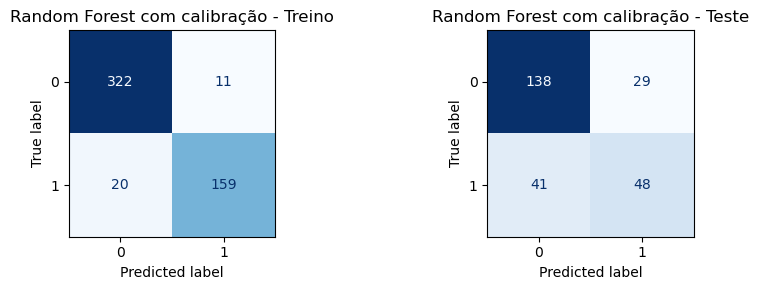

In [33]:
# Previsões no conjunto de treino
def predict_rndForest(rndforest_model, X_train,y_train,X_test,y_test ):

    # Previsões no conjunto de treino
    y_train_pred_cal = rndforest_model.predict(X_train)
    print("\nDesempenho no conjunto de Treino")
    print(classification_report(y_train, y_train_pred_cal))
    cm_train_cal = confusion_matrix(y_train, y_train_pred_cal)

    # Previsões no conjunto de teste
    y_test_pred_cal = rndforest_model.predict(X_test)
    print("\nDesempenho no conjunto de Teste")
    print(classification_report(y_test, y_test_pred_cal))
    cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

    print('Score dos dados de treino:', rndforest_model.score(X_train, y_train))
    print('Score dos dados de teste:', rndforest_model.score(X_test, y_test))

    # Plotar matrizes de confusão usando a função
    plot_confusion_matrices(cm_train_cal, cm_test_cal, 'Random Forest com calibração')

    return cm_test_cal
    
    
cm_teste_calibracao = predict_rndForest(rndforest_calibrated, X_train,y_train,X_test,y_test)

Explicar Processo, na sintese, e o que pode alterar no resultado do classificador

Limiar (validação cruzada): 0.3469387755102041
F1-Score com limiar: 0.6861313868613139
F1-Scores: [0.5180897250361794, 0.5615141955835962, 0.5761047463175123, 0.5906040268456376, 0.603448275862069, 0.6131907308377896, 0.6229508196721312, 0.6275992438563327, 0.6332046332046332, 0.6428571428571429, 0.6434426229508197, 0.6567796610169492, 0.6652173913043479, 0.6741573033707865, 0.684931506849315, 0.676056338028169, 0.6730310262529833, 0.6861313868613139, 0.68, 0.6785714285714286, 0.6824146981627297, 0.6775067750677507, 0.6816901408450704, 0.672514619883041, 0.6606606606606606, 0.654434250764526, 0.6222222222222222, 0.6019417475728155, 0.5928338762214984, 0.5819397993311036, 0.5802047781569966, 0.5644599303135889, 0.5673758865248227, 0.5387453874538746, 0.5019011406844106, 0.448, 0.41975308641975306, 0.351931330472103, 0.3288888888888889, 0.25925925925925924, 0.22009569377990432, 0.1691542288557214, 0.08333333333333333, 0.053763440860215055, 0.05405405405405406, 0.02197802197802198, 0.0220

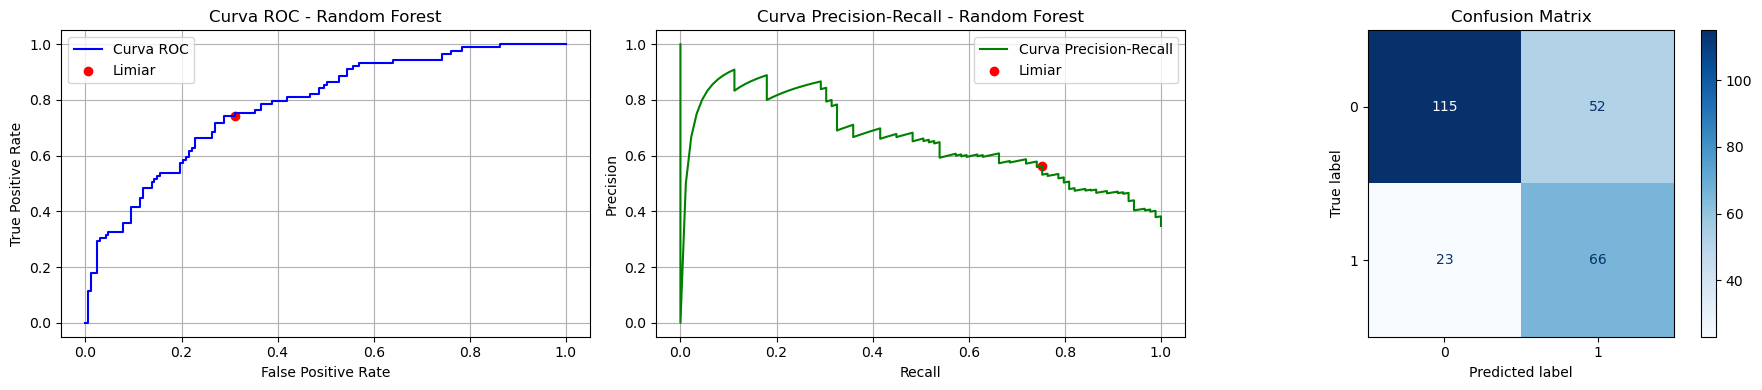

In [34]:
# Encontrar o limiar ótimo usando validação cruzada
def rndForest_with_threshold(X_train, y_train,X_test,y_test, cv,rndforest_best_params, rndforest_calibrated):
    best_threshold_f1, best_cv_f1, f1_scores = find_threshold(
        RandomForestClassifier(random_state=42),
        X_train,
        y_train,
        cv,
        param_grid=rndforest_best_params
    )

    print(f"Limiar (validação cruzada): {best_threshold_f1}")
    print(f"F1-Score com limiar: {best_cv_f1}")
    print(f"F1-Scores: {f1_scores}")

    # Obter probabilidades no conjunto de teste e aplicar novo limiar apenas á classe positiva
    y_test_proba = rndforest_calibrated.predict_proba(X_test)
    y_test_proba = y_test_proba[:,1] # Obtem as probabiliades da classe positiva
    y_test_pred_threshold = (y_test_proba >= best_threshold_f1).astype(int)
  
    # Calcular curvas para visualização
    # fp -> false positive
    # tp -> true positive
    fp, tp, thresholds_roc = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fp, tp)
    print("ROC AUC Score:", roc_auc)
    
    print(classification_report(y_test, y_test_pred_threshold))

    precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

    # thresholds_pr - best_threshold_f1 calcula a distancia entre 2 arrays
    # retorna a distancia absoluta, e nós queremos o valor minimo, que seria o limiar mais próximo, com base no f1-score
    # np.argmin retorna o index do array correspondente a valor do array que tem a menor distancia
    idx_closest = np.argmin(np.abs(thresholds_pr - best_threshold_f1))

    cm_test = confusion_matrix(y_test, y_test_pred_threshold)

    # Calcular pontos para os gráficos com limiar otimizado
    fp_threshold = cm_test[0, 1] / cm_test[0, :].sum()  # FP / (TN + FP)
    tp_threshold = cm_test[1, 1] / cm_test[1, :].sum()  # TP / (TP + FN)

    plot_threshold_analysis(
        fp, tp, roc_auc,
        recall_vals, precision_vals,
        cm_test,
        (fp_threshold, tp_threshold),
        (recall_vals[idx_closest], precision_vals[idx_closest]),
        'Random Forest',
    )
    return cm_test

cm_test_limiar = rndForest_with_threshold(X_train, y_train,X_test,y_test, cv,rndforest_best_params, rndforest_calibrated)

Pequeno texto a comparar as dusa matrizes de confusão

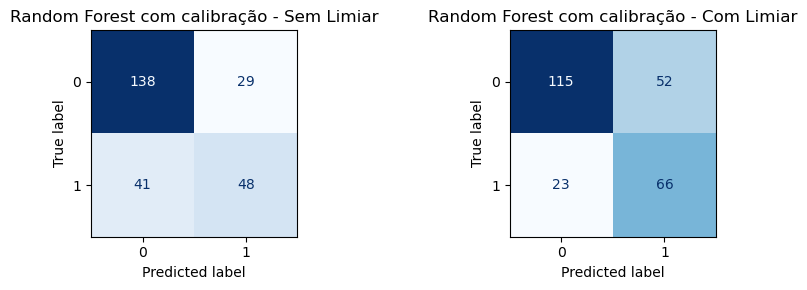

In [38]:
plot_CF(cm_teste_calibracao, cm_test_limiar, 'Random Forest com calibração - Sem Limiar', 'Random Forest com calibração - Com Limiar')

Meter aqui as árvores de decisão


Melhor árvore no índice 32 com uma acurracy de 0.7539


Text(0.5, 1.0, 'Melhor Árvore de decisão(no índice 32)')

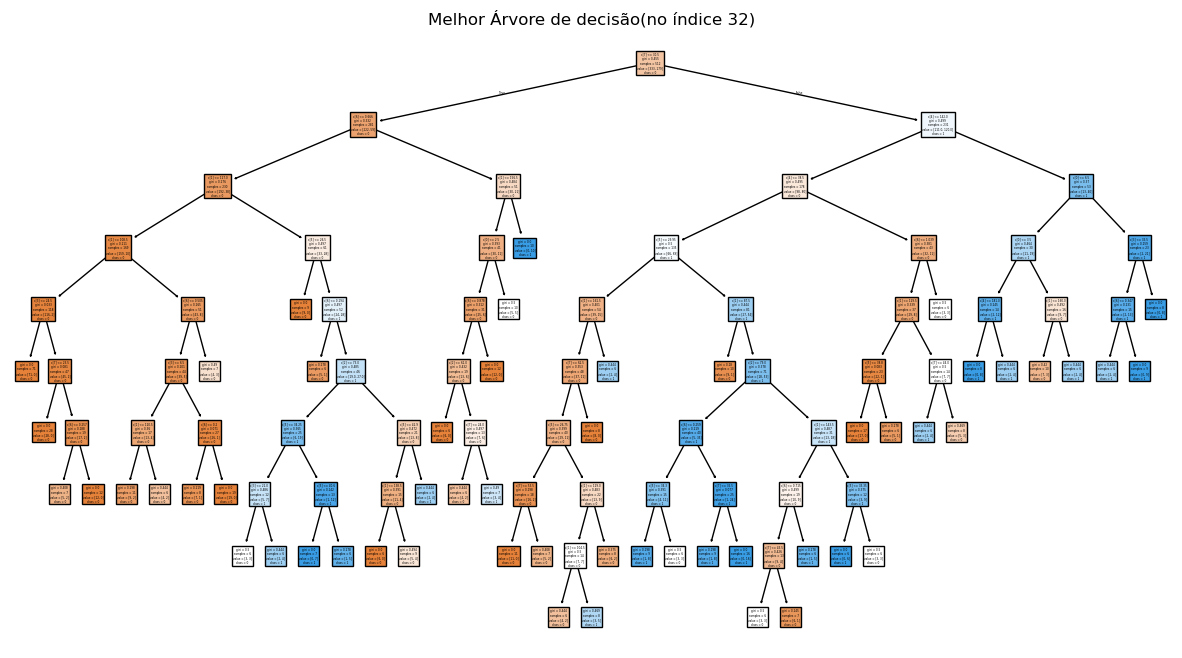

In [ ]:
# Encontrar a melhor árvore de decisão paras os dados de teste

from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

# Avaliar cada árvore individualmente
scores = []
for i, tree in enumerate(rndforest_calibrated.estimators_):
    y_pred = tree.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores.append(acc)

# Encontrar o índice da melhor árvore
best_idx = np.argmax(scores)
best_tree = rndforest_calibrated.estimators_[best_idx]
print(f"Melhor árvore no índice {best_idx} com uma acurracy de {scores[best_idx]:.4f}")

# Visualizar a melhor árvore
plt.figure(figsize=(15, 8))
plot_tree(
    best_tree,
    filled=True,
    feature_names=X.columns if hasattr(X, "columns") else None,
    class_names=[str(c) for c in np.unique(y)],
    max_depth=None     # coloque None se quiser visualizar a árvore completa
)
plt.title(f"Melhor Árvore de decisão(no índice {best_idx})")

### 3.2.3 - Linear Regression (Bruno)

#### TODO:
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar


### 3.2.4 - Análise dos classificadores
- Pegar nos dados dos 3 classificadores acima, e juntar num subplot de 3 figuras
    - Printar confusion matrix dos 3 (com os dados de teste)
    - Printar as curvas roc dos 3 ao mesmo tempo

## 3.3 - Pré-processamento (TODO)

- Demonstrar que os dados não estão normalizados
- falar como é que a não normalização afeta os modelos



Dado o contexto anterior, será necessário investigar o impacto da normalização (*StandardScaler*) no desempenho dos classificadores, especialmente para SVC e Logistic Regression, que são algoritmos que são sensiveis à escala dos dados. Esta estratégia de pré-processamento poderá melhorar o desempenho destes modelos.

### 3.3.1 - Standard Scaler

In [241]:
X_norm = StandardScaler().fit_transform(X)

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=1/3,stratify=y)

NameError: name 'StandardScaler' is not defined

### 3.3.2 - Treino com Pré-Processamento - SVC (Alice)

#### TODO:
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar

In [242]:
svc_calibrated_scaled, svc_best_params_scaled = calibrate_svc(param_grid_svc, X_train_norm, y_train_norm, cv)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}



Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       333
           1       0.78      0.60      0.68       179

    accuracy                           0.80       512
   macro avg       0.79      0.76      0.77       512
weighted avg       0.80      0.80      0.79       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       167
           1       0.73      0.54      0.62        89

    accuracy                           0.77       256
   macro avg       0.76      0.72      0.73       256
weighted avg       0.76      0.77      0.76       256



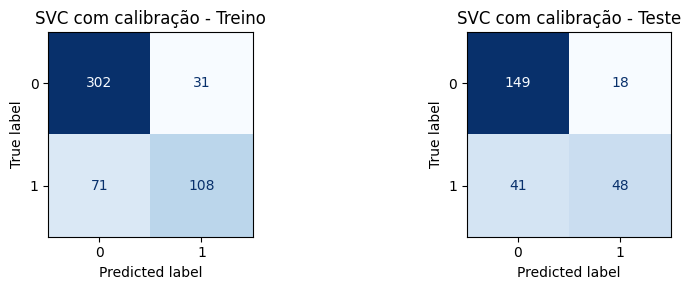

In [243]:
# Previsões no conjunto de treino
predict_svc(svc_calibrated_scaled, X_train_norm, y_train_norm, X_test_norm, y_test_norm)

Limiar (validação cruzada): 0.3061224489795918
F1-Score com limiar: 0.691358024691358
F1-Scores: [0.5180897250361794, 0.5174418604651163, 0.5212298682284041, 0.5329341317365269, 0.5462962962962963, 0.5631067961165048, 0.5805369127516778, 0.5989492119089317, 0.609981515711645, 0.6404715127701375, 0.6558044806517311, 0.6569037656903766, 0.6754385964912281, 0.6774193548387096, 0.689156626506024, 0.691358024691358, 0.6867167919799498, 0.6808510638297872, 0.6592797783933518, 0.655367231638418, 0.6608187134502924, 0.6428571428571429, 0.64, 0.63125, 0.6261980830670927, 0.6233766233766234, 0.6225165562913907, 0.5966101694915255, 0.5923344947735192, 0.5886524822695035, 0.5766423357664233, 0.556390977443609, 0.5214007782101168, 0.5138339920948617, 0.4816326530612245, 0.425531914893617, 0.38427947598253276, 0.36283185840707965, 0.35714285714285715, 0.3211009174311927, 0.31336405529953915, 0.26666666666666666, 0.23300970873786409, 0.208955223880597, 0.15384615384615385, 0.14432989690721648, 0.1052

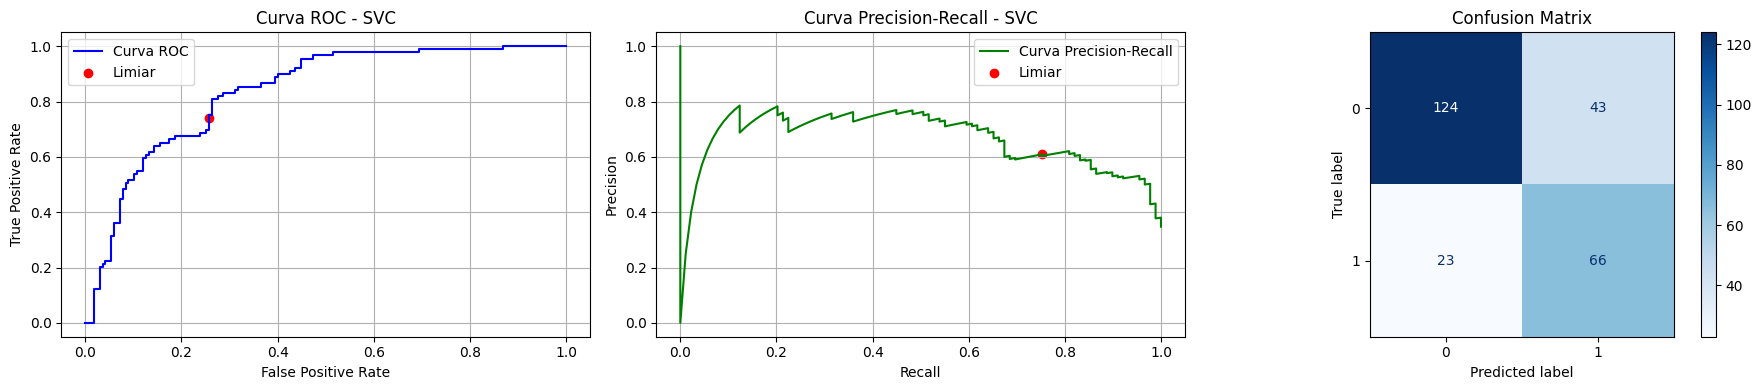

In [244]:
svc_with_threshold(X_train_norm, y_train_norm, X_test_norm, y_test_norm, cv, svc_best_params_scaled, svc_calibrated_scaled)

### 3.3.3 - Treino com Pré-Processamento - Linear Regression (Bruno)

#### TODO:
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar

### 3.3.4 - Treino com Pré-Processamento - Random Forest (Gui)

#### TODO:
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar

In [ ]:
rndforest_calibrated_scaled, rndForest_best_params_scaled = calibrate_rndForest(param_grid_RndForest, X_train_norm, y_train_norm, cv)

In [ ]:
# Previsões no conjunto de treino
predict_rndForest(rndforest_calibrated_scaled, X_train_norm, y_train_norm, X_test_norm, y_test_norm)

In [ ]:
rndForest_with_threshold(X_train_norm, y_train_norm, X_test_norm, y_test_norm, cv, rndForest_best_params_scaled, rndforest_calibrated_scaled)

### 3.3.5 - Análise dos classificadores
- Pegar nos dados dos 3 classificadores acima, e juntar num subplot de 3 figuras
    - Printar confusion matrix
    - Printar as curvas roc dos 3 ao mesmo tempo

## 4 - Conclusões




# 5 - Bibliografia

- https://mariofilho.com/precisao-recall-e-f1-score-em-machine-learning/ 
- https://studyeasy.org/pt/course-articles/machine-leaning-articles-pt/auc-and-pr-curve-background-pt/#binary-classification-a-primer
- https://www.geeksforgeeks.org/machine-learning/how-to-choose-the-best-kernel-function-for-svms/